# Modeling the Spread and Detection of Fake News in Social Media: Centralized, Crowdsourced, and Hybrid Strategies
_Authors: Beatriz Enríquez, Daniel Arias & Zehra Özeren_

## Introduction
The rapid spread of fake news on social media has become a pressing issue with significant social implications. The dissemination of misinformation can influence public opinion, interfere with democratic processes, and contribute to the polarization of communities [1]. Traditionally, social media platforms have relied on professional fact-checkers to review and label misleading content [2], such as AFP USA, Check Your Fact, Factcheck.org, Lead Stories, PolitiFact, Science Feedback, Reuters Fact Check, TelevisaUnivision, The Dispatch and USA TODAY.

However, new approaches are being explored. One such approach is the crowdsourced model (also knows as Community Notes), in which users themselves participate in the identification and contextualization of potentially misleading content. This method has gained traction on platforms such as X (formerly Twitter), where users contribute to a collective fact-checking process. Meta, the parent company of Facebook and Instagram, has also announced plans to move toward this model [3], signaling a shift from centralized moderation to decentralized, community-driven verification.

From a complex network perspective, this problem is particularly intriguing. Social networks can be represented as graphs, where nodes correspond to users and edges to interactions or relationships. By modeling different strategies for fake news detection and mitigation, we can evaluate their effectiveness and robustness under various network conditions.

## Project Objectives and Methodology
The goal of this project is to study the propagation of fake news through complex networks and to compare the effectiveness of different detection and mitigation strategies. We propose to develop and simulate three distinct models:

- **Centralized Detection Model**: In this model, a subset of nodes is designated as professional or algorithmic fact-checkers. These nodes are responsible for identifying and stopping the spread of fake news. This setup simulates the traditional centralized approach used by platforms such as Facebook prior to the shift to crowdsourcing.

- **Crowdsourced Detection Model**: Here, the entire network is involved in the verification process. Each node (user) has the ability to vote on the veracity of a piece of information. The propagation of fake news depends on the collective response of the network. This model represents the new paradigm being explored by platforms like Meta and X.

- **Hybrid Model**: Inspired by recent academic proposals [4], this model combines the previous two approaches. A small group of expert nodes works alongside the crowd to evaluate the information. The final decision on the truthfulness of the news is based on a weighted combination of expert opinion and crowd consensus.

Each model will be implemented and tested on synthetic networks (e.g., Barabasi-Albert) to assess their behavior under different topologies. Key metrics such as speed of propagation, fraction of nodes exposed to fake news, and effectiveness in containing misinformation will be analyzed.

The results of this study could provide insight into the trade-offs between centralized and decentralized moderation, and how network structure influences the spread and detection of fake news.

In [ ]:
import networkx as nx
import numpy as np
from seir_model import simulate_seir, plot_seir

# Network
N = 10000
G = nx.barabasi_albert_graph(N, 30)

# SEIR Parameters (based on stiffness analysis)
beta = 0.03      # infection/contact rate
delta = 0.4      # decision rate
mu = 0.5         # probability of stopping spreading
gamma = 0.001     # backfire probability (R to I)
Tmax = 150

## 1. Centralized Detection Model

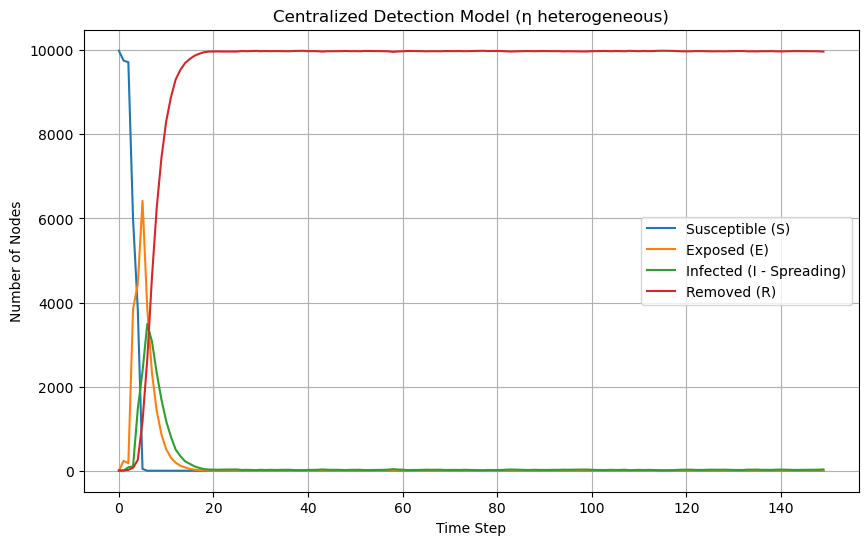

In [ ]:
# Initial infection
initial_infected = np.random.choice(G.nodes, size=10, replace=False)
initial_state = {node: 'I' for node in initial_infected}

# Centralized model: Only a subset (10%) are expert detectors
eta = np.zeros(N)
experts = np.random.choice(range(N), size=int(0.1 * N), replace=False)
eta[experts] = 1.0

# Simulate
history_centralized = simulate_seir(G, beta, delta, mu, gamma, eta, initial_state, Tmax)
plot_seir(history_centralized, title="Centralized Detection Model (η heterogeneous)")

## 2. Crowsourced Detection Model

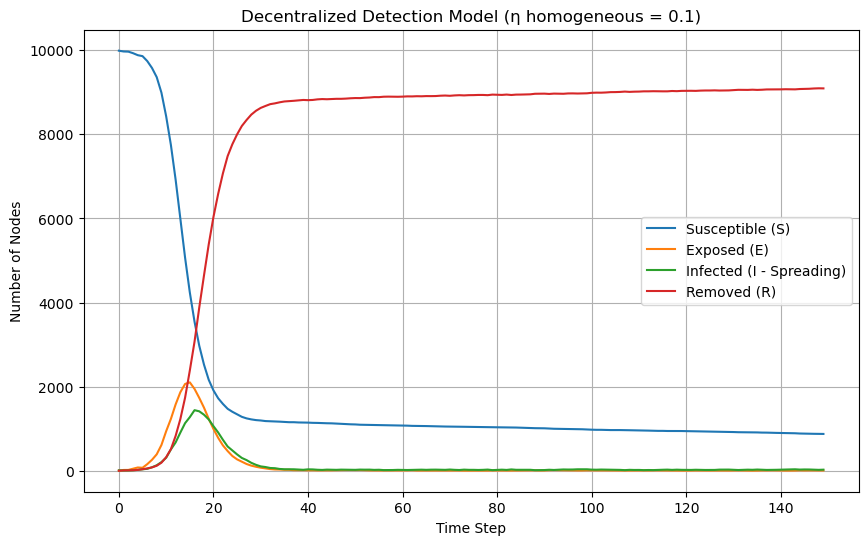

In [3]:
# Decentralized model: All nodes have the same detection ability
eta_uniform = np.full(N, 0.1)  # Moderate awareness across all nodes

# Initial infection
initial_infected = np.random.choice(G.nodes, size=10, replace=False)
initial_state = {node: 'I' for node in initial_infected}

# Simulate
history_decentralized = simulate_seir(G, beta, delta, mu, gamma, eta_uniform, initial_state, Tmax)
plot_seir(history_decentralized, title="Decentralized Detection Model (η homogeneous = 0.1)")

## 3. Hybrid Detection Model

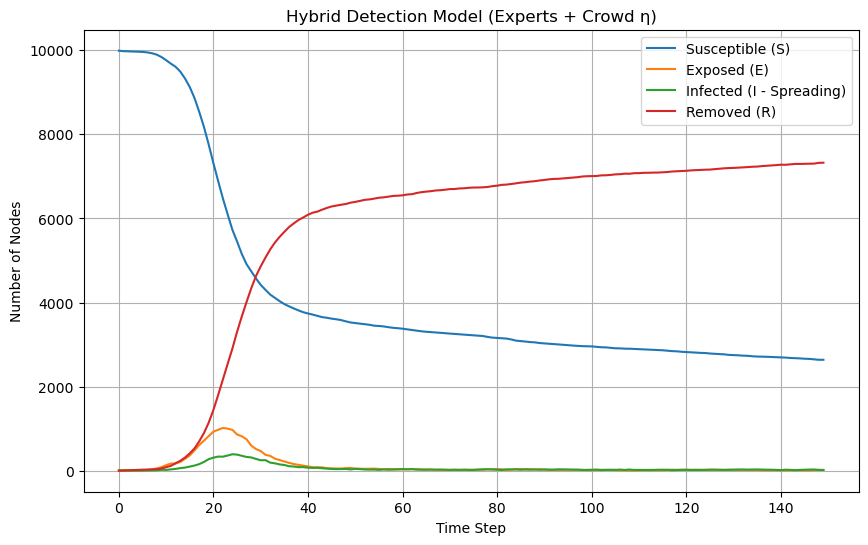

In [4]:
# Hybrid model: mix of expert and non-expert nodes
eta_hybrid = np.full(N, 0.5)  # General crowd awareness
experts = np.random.choice(range(N), size=int(0.05 * N), replace=False)
eta_hybrid[experts] = 1.0     # Experts with perfect detection

# Initial infection
initial_infected = np.random.choice(G.nodes, size=10, replace=False)
initial_state = {node: 'I' for node in initial_infected}

# Simulate
history_hybrid = simulate_seir(G, beta, delta, mu, gamma, eta_hybrid, initial_state, Tmax)
plot_seir(history_hybrid, title="Hybrid Detection Model (Experts + Crowd η)")

## Stiffness Analysis

Top 5 most stable and least stiff parameter combinations:
   delta  eta   mu  gamma    λ_max_real  λ_min_real  stiffness_ratio  stable
0    0.4  0.5  0.5   0.01 -2.523886e-16   -0.795383       470.431295    True
1    0.5  0.5  0.5   0.01 -4.647545e-16   -0.880783       515.368270    True
2    0.4  0.6  0.5   0.01 -1.341489e-16   -0.759366       553.509887    True
3    0.6  0.5  0.5   0.01 -1.886709e-17   -0.969241       563.050530    True
4    0.3  0.7  0.5   0.01 -9.692324e-16   -0.651197       571.005821    True


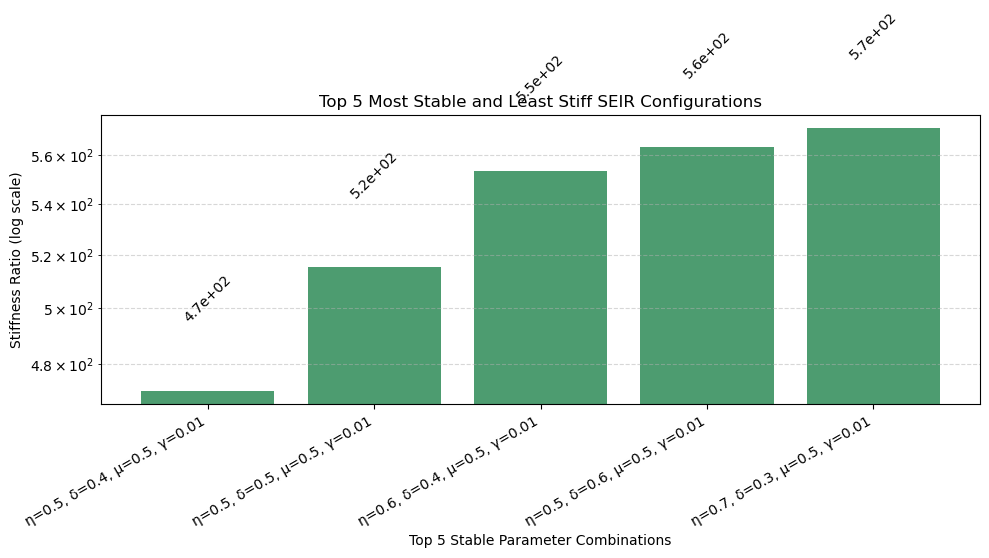

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Fixed parameters
beta = 0.6
N = 1.0     # Normalized total population
S0 = 0.95
I0 = 0.02

# Parameter ranges to test
delta_values = [0.3, 0.4, 0.5, 0.6]
eta_values = [0.4, 0.5, 0.6, 0.7, 0.8]
mu_values = [0.1, 0.2, 0.3, 0.4, 0.5]
gamma_values = [0.01, 0.02, 0.03]

# Store results
results = []

for delta in delta_values:
    for eta in eta_values:
        for mu in mu_values:
            for gamma in gamma_values:
                # Construct Jacobian matrix
                J = np.array([
                    [-beta * I0 / N, 0, -beta * S0 / N, 0],
                    [ beta * I0 / N, -delta, beta * S0 / N, 0],
                    [0, (1 - eta) * delta, -mu, gamma],
                    [0, eta * delta, mu, -gamma]
                ])

                # Eigenvalues and stiffness ratio
                eigvals = np.linalg.eigvals(J)
                eigvals_real = np.real(eigvals)
                abs_eigvals = np.abs(eigvals)
                try:
                    stiffness_ratio = abs_eigvals.max() / abs_eigvals[abs_eigvals > 1e-12].min()
                except:
                    stiffness_ratio = np.inf
                is_stable = np.all(eigvals_real < 0)

                # Store
                results.append({
                    'delta': delta,
                    'eta': eta,
                    'mu': mu,
                    'gamma': gamma,
                    'λ_max_real': eigvals_real.max(),
                    'λ_min_real': eigvals_real.min(),
                    'stiffness_ratio': stiffness_ratio,
                    'stable': is_stable
                })

# Create DataFrame
df = pd.DataFrame(results)

# Filter only stable systems and sort by lowest stiffness
stable_df = df[df['stable'] == True]
top5_best = stable_df.sort_values('stiffness_ratio').head(5).reset_index(drop=True)

# Print results
print("Top 5 most stable and least stiff parameter combinations:")
print(top5_best)

# Plot top 5
plt.figure(figsize=(10, 6))
bars = plt.bar(
    x=top5_best.index,
    height=top5_best['stiffness_ratio'],
    tick_label=[f'η={r["eta"]}, δ={r["delta"]}, μ={r["mu"]}, γ={r["gamma"]}' for _, r in top5_best.iterrows()],
    color='seagreen',
    alpha=0.85
)

# Add annotations
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height * 1.05, f'{height:.1e}', 
             ha='center', va='bottom', fontsize=10, rotation=45)

plt.yscale('log')
plt.ylabel("Stiffness Ratio (log scale)")
plt.xlabel("Top 5 Stable Parameter Combinations")
plt.title("Top 5 Most Stable and Least Stiff SEIR Configurations")
plt.xticks(rotation=30, ha='right')
plt.grid(True, which='both', axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Symbolic Jacobian

In [ ]:
import sympy as sp

# Symbolic variables
S, E, I, R, N = sp.symbols('S E I R N')
beta, delta, eta, mu, gamma = sp.symbols('beta delta eta mu gamma')

# Define the equations
dS_dt = -beta * S * I / N
dE_dt = beta * S * I / N - delta * E
dI_dt = (1 - eta) * delta * E + gamma * R - mu * I
dR_dt = eta * delta * E + mu * I - gamma * R

# Vector of equations and variables
F = sp.Matrix([dS_dt, dE_dt, dI_dt, dR_dt])
X = sp.Matrix([S, E, I, R])

J = F.jacobian(X)
sp.pprint(J)


⎡-I⋅β              -S⋅β     ⎤
⎢─────      0      ─────  0 ⎥
⎢  N                 N      ⎥
⎢                           ⎥
⎢ I⋅β               S⋅β     ⎥
⎢ ───      -δ       ───   0 ⎥
⎢  N                 N      ⎥
⎢                           ⎥
⎢  0    δ⋅(1 - η)   -μ    γ ⎥
⎢                           ⎥
⎣  0       δ⋅η       μ    -γ⎦


## Stability Curve

Parameters used:
  β = 0.6
  δ = 0.4
  μ = 0.5
  γ = 0 and 0.001
----------------------------------------
Critical η (for γ = 0) where λₘₐₓ < 0.0001: ηₛ ≈ 0.1667


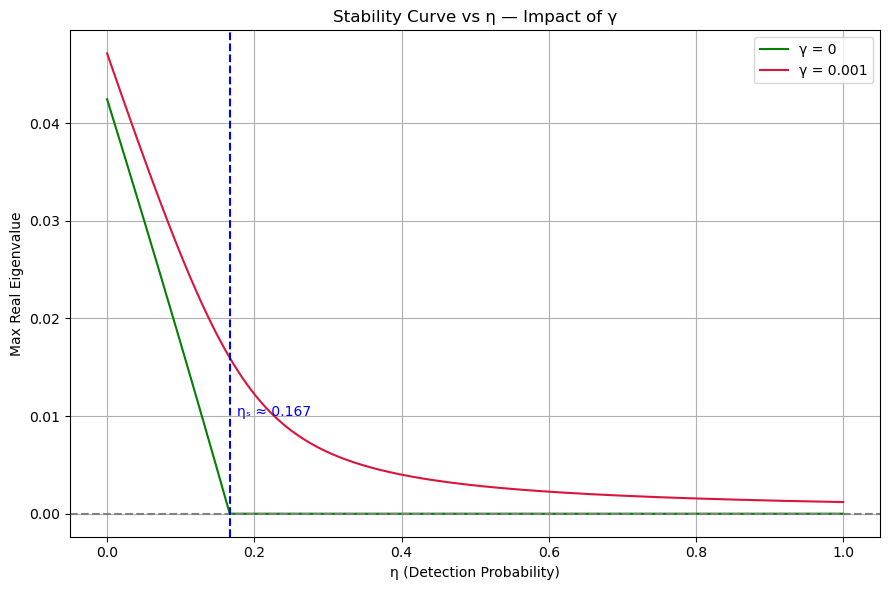

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, Matrix, lambdify

# Symbolic variables
S, E, I, R, N = symbols('S E I R N')
beta, delta, eta, mu, gamma = symbols('beta delta eta mu gamma')

# Define SEIR equations
dS_dt = -beta * S * I / N
dE_dt = beta * S * I / N - delta * E
dI_dt = (1 - eta) * delta * E + gamma * R - mu * I
dR_dt = eta * delta * E + mu * I - gamma * R

F = Matrix([dS_dt, dE_dt, dI_dt, dR_dt])
X = Matrix([S, E, I, R])
J = F.jacobian(X)

# Evaluate at DFE: S=N=1, I=0
subs = {S: 1, I: 0, N: 1}
J_DFE = J.subs(subs)

# Parameters
param_vals = {
    'beta': 0.6,
    'delta': 0.4,
    'mu': 0.5,
    'gamma': [0, 0.001]
}

# Print used parameters
print("Parameters used:")
print(f"  β = {param_vals['beta']}")
print(f"  δ = {param_vals['delta']}")
print(f"  μ = {param_vals['mu']}")
print(f"  γ = {param_vals['gamma'][0]} and {param_vals['gamma'][1]}")
print("-" * 40)

eta_vals = np.linspace(0, 1, 500)
threshold = 1e-4  # tolerance for zero-crossing

def compute_lambda_max(gamma_val):
    vals = {
        beta: param_vals['beta'],
        delta: param_vals['delta'],
        mu: param_vals['mu'],
        gamma: gamma_val
    }
    J_eta = J_DFE.subs(vals)
    J_func = lambdify(eta, J_eta, 'numpy')
    results = []
    for eta_val in eta_vals:
        J_eval = J_func(eta_val)
        eigvals = np.linalg.eigvals(J_eval)
        results.append(np.max(np.real(eigvals)))
    return np.array(results)

def find_eta_c(eta_vals, lambda_vals, eps=1e-4):
    for i in range(1, len(lambda_vals)):
        if lambda_vals[i-1] > eps and lambda_vals[i] < eps:
            # Linear interpolation
            eta1, eta2 = eta_vals[i-1], eta_vals[i]
            lam1, lam2 = lambda_vals[i-1], lambda_vals[i]
            eta_c = eta1 - lam1 * (eta2 - eta1) / (lam2 - lam1)
            return eta_c
    return None

# Compute eigenvalue curves
lambda_0 = compute_lambda_max(param_vals['gamma'][0])
lambda_001 = compute_lambda_max(param_vals['gamma'][1])
eta_c = find_eta_c(eta_vals, lambda_0, eps=threshold)

# Print critical eta if found
if eta_c:
    print(f"Critical η (for γ = 0) where λₘₐₓ < {threshold}: ηₛ ≈ {eta_c:.4f}")
else:
    print("No η found where λₘₐₓ < threshold — system may remain unstable.")

# Plot
plt.figure(figsize=(9, 6))
plt.plot(eta_vals, lambda_0, label='γ = 0', color='green')
plt.plot(eta_vals, lambda_001, label='γ = 0.001', color='crimson')
plt.axhline(0, color='gray', linestyle='--')

if eta_c:
    plt.axvline(eta_c, linestyle='--', color='blue')
    plt.text(eta_c + 0.01, 0.01, f'ηₛ ≈ {eta_c:.3f}', color='blue')

plt.xlabel("η (Detection Probability)")
plt.ylabel("Max Real Eigenvalue")
plt.title("Stability Curve vs η — Impact of γ")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Steady-state Analysis

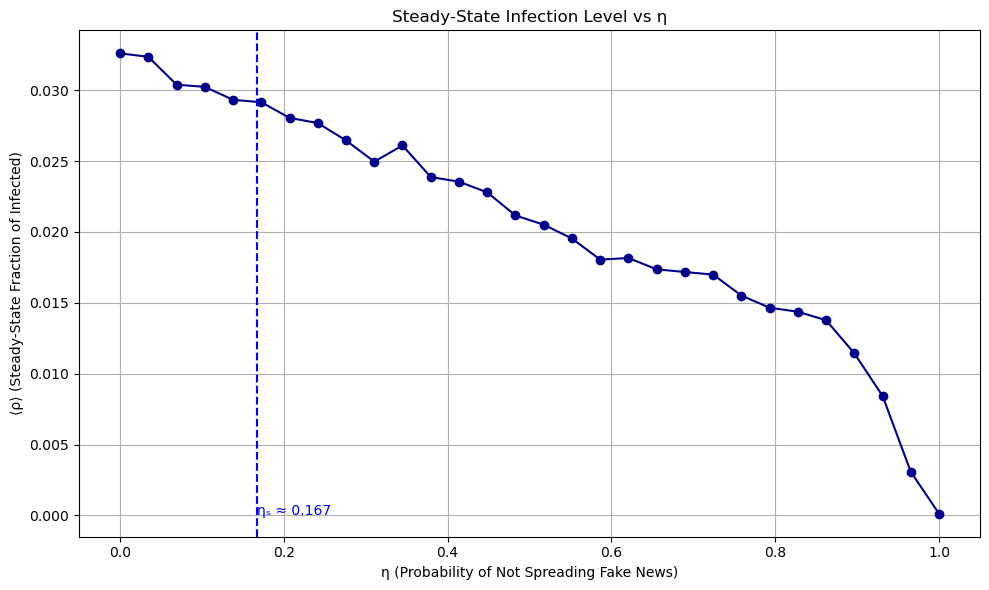

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from seir_model import simulate_seir  # Your previously defined SEIR simulator

def steady_state_infection_vs_eta(beta=0.6, delta=0.4, mu=0.5, gamma=0.01, Tmax=150, N=1000, k=6, Nrep=10):
    eta_values = np.linspace(0, 1, 30)
    avg_final_infections = []

    for eta_val in eta_values:
        infected_final = []
        for _ in range(Nrep):
            # Create BA network
            G = nx.barabasi_albert_graph(N, k)
            
            # Define per-node η
            eta = np.full(N, eta_val)
            
            nodes = list(G.nodes)
            np.random.shuffle(nodes)
            initial_infected = nodes[:10]
            initial_state = {node: 'I' for node in initial_infected}
            
            # Run simulation
            history = simulate_seir(G, beta, delta, mu, gamma, eta, initial_state, Tmax)
            
            # Get average of last 10 steps of I
            last_Is = [step['I'] for step in history[-10:]]
            avg_I = np.mean(last_Is) / N
            infected_final.append(avg_I)

        avg_final_infections.append(np.mean(infected_final))

    plt.figure(figsize=(10, 6))
    plt.plot(eta_values, avg_final_infections, marker='o', color='darkblue')

    plt.axvline(0.167, linestyle='--', color='blue')
    plt.text(x=0.167, y=0, s=f'ηₛ ≈ 0.167', color='blue')


    plt.xlabel('η (Probability of Not Spreading Fake News)')
    plt.ylabel('⟨ρ⟩ (Steady-State Fraction of Infected)')
    plt.title('Steady-State Infection Level vs η')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


steady_state_infection_vs_eta(
    beta=0.6,
    delta=0.4,
    mu=0.5,
    gamma=0.001,
    Tmax=20,
    N=10000,
    k=30,
    Nrep=20
)


## References
[1] J. Thebault-Spieker, S. Venkatagiri, N. Mine, and K. Luther, “Diverse perspectives can mitigate political bias in crowdsourced content moderation,” in 2023 ACM Conference on Fairness Accountability and Transparency, ser. FAccT ’23. ACM, Jun. 2023, p. 1280–1291. [Online]. Available: http://dx.doi.org/10.1145/3593013.3594080

[2] M. T. Center, “How fact-checking works,” 2025, accessed: May 6, 2025. [Online]. Available: https://transparency.meta.com/en-gb/features/how-fact-checking-works/

[3] C. G. A. O. Joel Kaplan, “More speech and fewer mistakes,” 2025, accessed: May 6, 2025. [Online]. Available: https://about.fb.com/news/2025/01/meta-more-speech-fewer-mistakes/